In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pickle

# Related to Jaxley issue #375
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from jaxley_retina.mnist.model import build_mnist_model
from jaxley_retina.mnist.train_io import load_conductances

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
model_config = {
    'BC_readouts': True,
    'connections': 'local',
    'nHCs': 9,
    'nPRs': 200,
    'n_rad': 50,
    'n_readouts': 10,
    'ptc_path': '../../params/cascade/params_3.pkl',
    'ribbon_path': '../../params/ribbon/best_20_params.pkl'
}
stim_config = {
        'digits': 'all',
        'dt': 0.025,
        'outer_ramp_up': 1000,
        'peak_end': 50,
        'peak_start': 0,
        'phi_max': 40000,
        't_max': 200,
        'test_contrast_max': 1.0,
        'test_contrast_min': 0.1,
        'test_lum_max': 0.1,
        'test_lum_min': 0.0,
        'train_contrast_max': 1.0,
        'train_contrast_min': 0.1,
        'train_lum_max': 0.1,
        'train_lum_min': 0.0,
}
train_config =  {
    'IonotropicSynapse_gS_init': 'normal',
    'IonotropicSynapse_gS_init_mean': 0.01,
    'IonotropicSynapse_gS_init_std': 0.001,
    'IonotropicSynapse_gS_lower': -20,
    'IonotropicSynapse_gS_upper': -3,
    'RibbonHC_gS_init': 'normal',
    'RibbonHC_gS_init_mean': 1.0e-07,
    'RibbonHC_gS_init_std': 1.0e-08,
    'RibbonHC_gS_lower': -25,
    'RibbonHC_gS_upper': -5,
    'RibbonReadout_gS_init': 'normal',
    'RibbonReadout_gS_init_mean': 1.0e-06,
    'RibbonReadout_gS_init_std': 1.0e-07,
    'RibbonReadout_gS_lower': -20,
    'RibbonReadout_gS_upper': -3,
    'batch_size': 32,
    'checkpoint_lengths': [20, 20, 20],
    'decay_rate': 0.9,
    'loss_start': 0,
    'max_epochs': 5,
    'notes': 'exponential decay on lr, no regularization',
    'seed': 0,
    'start_lr': 0.01,
    'stop_criteria': 0.995,
    'transition_steps': 1000,
    'weight_sharing': False,
}

In [18]:
# Rebuild the model (for mapping conductances correctly and getting coords)
network = build_mnist_model(model_config)
network.PR.compute_compartment_centers()
coords = np.vstack((network.PR.nodes.x, network.PR.nodes.y))

In [19]:
conductance_params = load_conductances("../../params/mnist/trained_params_0504_209_fulldist.pkl")

In [20]:
# Get the weights to the readouts
PR_to_HC = conductance_params["RibbonHC_gS"]
PR_to_readout = conductance_params["RibbonReadout_gS"]

network.copy_node_property_to_edges("global_comp_index")

readout_post_comps = network.RibbonReadout.edges.post_global_comp_index.to_numpy()
unique_post_comps = np.unique(readout_post_comps)
gs_by_readout = []
for i in unique_post_comps:
    param_idxs = np.where(readout_post_comps == i)[0]
    gs_by_readout.append(PR_to_readout[param_idxs])

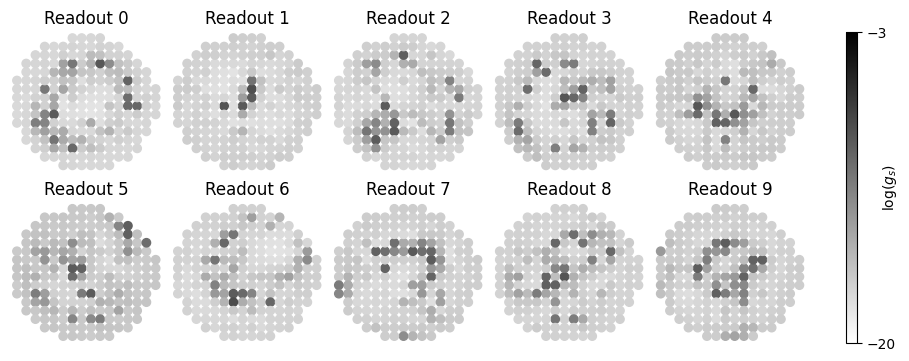

In [21]:
# Preliminary plot
fig, axs = plt.subplots(2, 5, figsize=(9, 3.5), constrained_layout=True)
for i, ax in enumerate(axs.ravel()):
    im = ax.scatter(coords[0], coords[1], c=np.log(gs_by_readout[i]), cmap="binary", vmin=-20, vmax=-3)
    ax.set_title(f"Readout {i}")
    ax.axis("off")
    ax.axis("off")
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), aspect=30)
cbar.set_label(r"$\log(g_s)$", labelpad=-10)
cbar.set_ticks([-3, -20])
plt.show()

In [22]:
# Save the data for figure assembly
with open("../../paper/fig5/notebooks/fig5_0504_209.pkl", "wb") as f:
    pickle.dump({
        "conductances": gs_by_readout,
        "coords": coords,
    }, f)